<a href="https://colab.research.google.com/github/javed-web/Movie-Review-Sentiment-Analysis/blob/main/21f1001589_notebook_t22023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re, string, ast
import matplotlib.pyplot as plt
import seaborn as sns

#import xgboost as xgb
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.ensemble import RandomForestClassifier

# Data Loading, Exploration

In [ ]:
data1 = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
data2 = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [ ]:
# Display the first few rows of the dataset
data1.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [ ]:
print(data1.shape)

(162758, 5)


In [ ]:
# Check data types
print(data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


In [ ]:
data2.shape

(143258, 14)

In [ ]:
# Drop the duplicates in data2
data2.drop_duplicates(subset=['movieid'], inplace=True)

In [ ]:
data2.shape # 16,854 Duplicates were dropped

(126404, 14)

In [ ]:
# Display the first few rows of the dataset
data2.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [ ]:
# Check data types
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 0 to 143256
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               126404 non-null  object 
 1   title                 126404 non-null  object 
 2   audienceScore         63714 non-null   float64
 3   rating                11778 non-null   object 
 4   ratingContents        11778 non-null   object 
 5   releaseDateTheaters   26390 non-null   object 
 6   releaseDateStreaming  69273 non-null   object 
 7   runtimeMinutes        113910 non-null  float64
 8   genre                 116401 non-null  object 
 9   originalLanguage      114020 non-null  object 
 10  director              126404 non-null  object 
 11  boxOffice             12528 non-null   object 
 12  distributor           19549 non-null   object 
 13  soundType             13466 non-null   object 
dtypes: float64(2), object(12)
memory usage: 14.5+ MB
Non

In [ ]:
# Merge the data based on the movie ID
data = pd.merge(data1, data2, on='movieid', how='left')

In [ ]:
# Drop unnecessary columns
data = data.drop(['rating', 'originalLanguage', 'runtimeMinutes','title', 'movieid', 'reviewerName', 'soundType', 'distributor', 'boxOffice', 'releaseDateStreaming', 'releaseDateTheaters'], axis=1)

# Exploratory Data Analysis (EDA)

In [ ]:
data.shape

(162758, 7)

In [ ]:
# Check data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   isFrequentReviewer  162758 non-null  bool   
 1   reviewText          156311 non-null  object 
 2   sentiment           162758 non-null  object 
 3   audienceScore       149510 non-null  float64
 4   ratingContents      99034 non-null   object 
 5   genre               160320 non-null  object 
 6   director            162758 non-null  object 
dtypes: bool(1), float64(1), object(5)
memory usage: 8.8+ MB


In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

isFrequentReviewer        0
reviewText             6447
sentiment                 0
audienceScore         13248
ratingContents        63724
genre                  2438
director                  0
dtype: int64


In [ ]:
# Fill the missing values
data['reviewText'].fillna(value='', inplace=True)
data['genre'].fillna(value='', inplace=True)
data['ratingContents'] = data['ratingContents'].fillna(pd.Series([[]] * len(data)))
data['audienceScore'] = data['audienceScore'].fillna(0.0)

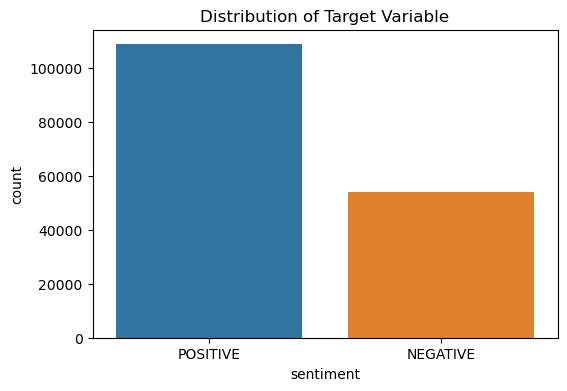

In [ ]:
# Countplot of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data)
plt.title('Distribution of Target Variable')
plt.show()

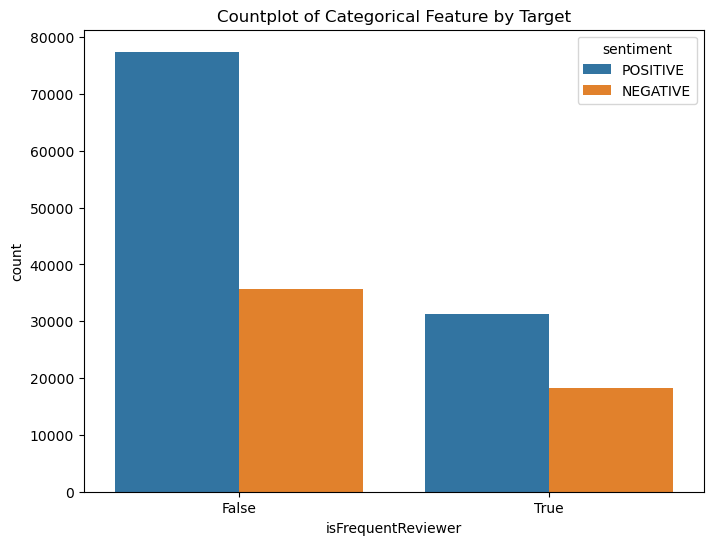

In [ ]:
# Countplot of a categorical feature against the target
plt.figure(figsize=(8, 6))
sns.countplot(x='isFrequentReviewer', hue='sentiment', data=data)
plt.title('Countplot of Categorical Feature by Target')
plt.show()

# Data Preprocessing

In [ ]:
# Function to preprocess the reviewtext
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters (except for spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('utf-8')

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize the text into individual words or tokens
    tokens = text.split()

    # Remove short words (less than 3 characters)
    tokens = [token for token in tokens if len(token) > 2]

    # Convert tokens back to text
    text = ' '.join(tokens)

    return text

# Feature Extraction

In [ ]:
# Preprocessing: Apply text preprocessing to 'reviewText'
data['reviewText'] = data['reviewText'].apply(preprocess_text)

In [ ]:
# Create a pipeline for text feature 'reviewText'
text_preprocessor = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=15000))
])

# Encoding the categorical features

In [ ]:
# Create a pipeline for Categorical features 'genre, ratingContents', 'director'
categorical_preprocessor = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [ ]:
# Converting the boolean and text data into Numerical 0's and 1's
data['isFrequentReviewer'] = data['isFrequentReviewer'].map({True: 1, False: 0})
data['sentiment'] = data['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})

# Feature Scaling

In [ ]:
# Create a pipeline for Numerical feature 'audienceScore'
numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

In [ ]:
# Convert the string representation of lists into actual lists
data['ratingContents'] = data['ratingContents'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Preprocessing: Remove square brackets and convert each list into a string
data['ratingContents'] = data['ratingContents'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Column Transformer

In [ ]:
# Create a column transformer to apply the pipelines to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_preprocessor, 'reviewText'),
        ('categorical', categorical_preprocessor, ['genre', 'ratingContents', 'director']),
        ('numerical', numerical_preprocessor, ['audienceScore'])
    ],
    remainder='drop'
)

In [ ]:
missing_values = data.isnull().sum()
print(missing_values)

isFrequentReviewer    0
reviewText            0
sentiment             0
audienceScore         0
ratingContents        0
genre                 0
director              0
dtype: int64


In [ ]:
# Split the data into features (X) and target (y)
X = data.drop('sentiment', axis=1)
y = data['sentiment'].values

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Gradient Boost: 0.6898
#XG Boost: 0.7552, 0.7962 features: 15000

# Model

In [ ]:
model = LogisticRegression(random_state=42)
#model = xgb.XGBClassifier(random_state=42)
#model = RandomForestClassifier(random_state=42)

# Cross Validation and Hyper Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
'''param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [None, 10, 20, 30]
}'''

# Define the hyperparameter grid for LogisticRegression
param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter
    'classifier__max_iter': [800, 1000, 1200],   # Maximum number of iterations
    'classifier__penalty': ['l1', 'l2'],       # Regularization type
    'classifier__solver': ['liblinear'],       # Solver for optimization
}

# Create a new pipeline with the ColumnTransformer, LogisticRegression, and GridSearchCV
pipeline = Pipeline([
    ('pipeline', preprocessor),
    ('classifier', model)
])

# Initialize GridSearchCV with the pipeline and hyperparameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted')

# Training

In [ ]:
# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV
best_model = grid_search.best_estimator_

# Refit the best model on the entire training dataset
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the F1 score on the test data
f1 = f1_score(y_test, y_pred, average='weighted')
print("Best XGB F1 Score:", f1)

Best XGB F1 Score: 0.7961045011578907


# New test data

In [ ]:
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

# Merge the data based on the movie ID
test = pd.merge(test, data2, on='movieid', how='left')

# Drop unnecessary columns
test = test.drop(['rating', 'originalLanguage', 'runtimeMinutes','title', 'movieid', 'reviewerName', 'soundType', 'distributor', 'boxOffice', 'releaseDateStreaming', 'releaseDateTheaters'], axis=1)
test.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)

missing_values = test.isnull().sum()
print(missing_values)

isFrequentReviewer        0
reviewText             2510
audienceScore          4931
ratingContents        24296
genre                   920
director                  0
dtype: int64


In [ ]:
# Fill the missing values
test['reviewText'].fillna(value='', inplace=True)
test['genre'].fillna(value='', inplace=True)
test['audienceScore'] = test['audienceScore'].fillna(0.0)
test['ratingContents'] = test['ratingContents'].fillna(pd.Series([[]] * len(test)))

In [ ]:
missing_values = test.isnull().sum()
print(missing_values)

isFrequentReviewer    0
reviewText            0
audienceScore         0
ratingContents        0
genre                 0
director              0
dtype: int64


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isFrequentReviewer  55315 non-null  bool   
 1   reviewText          55315 non-null  object 
 2   audienceScore       55315 non-null  float64
 3   ratingContents      55315 non-null  object 
 4   genre               55315 non-null  object 
 5   director            55315 non-null  object 
dtypes: bool(1), float64(1), object(4)
memory usage: 2.6+ MB


In [ ]:
test['reviewText'] = test['reviewText'].apply(preprocess_text)

In [ ]:
# Convert the string representation of lists into actual lists
test['ratingContents'] = test['ratingContents'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Preprocessing: Remove square brackets and convert each list into a string
test['ratingContents'] = test['ratingContents'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
test['isFrequentReviewer'] = test['isFrequentReviewer'].map({True: 1, False: 0})

In [ ]:
best_model

Pipeline(steps=[('pipeline',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=15000))]),
                                                  'reviewText'),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['genre', 'ratingContents',
                                                   'director']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['audienceScore'])])),
                ('classifier',
                 LogisticRegression(max_iter=800, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [ ]:
# Transform the new test data using the preprocessor within the best model
X_test_new = best_model.named_steps['pipeline'].transform(test)

In [ ]:
# Make predictions on the test data using the best model
y_pred_test = best_model.named_steps['classifier'].predict(X_test_new)

# Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
class_names = ['POSITIVE', 'NEGATIVE']
report = classification_report(y_test, y_pred, target_names=class_names)

print(report)

              precision    recall  f1-score   support

    POSITIVE       0.75      0.60      0.67     10696
    NEGATIVE       0.82      0.90      0.86     21856

    accuracy                           0.80     32552
   macro avg       0.78      0.75      0.76     32552
weighted avg       0.80      0.80      0.80     32552



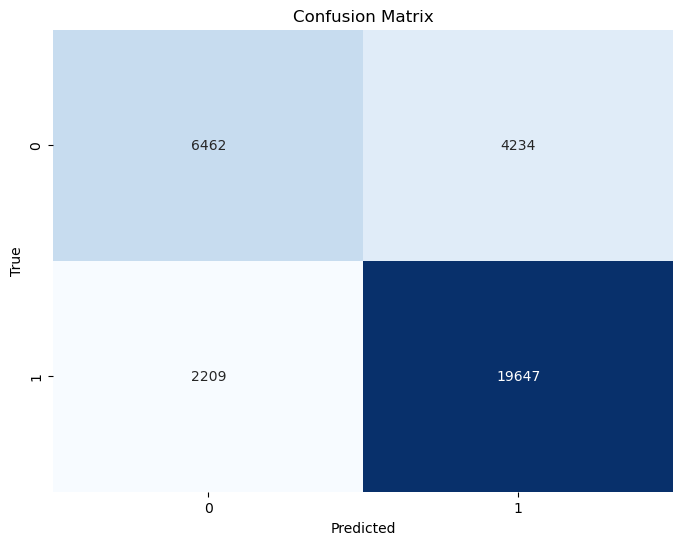

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Model Comparision

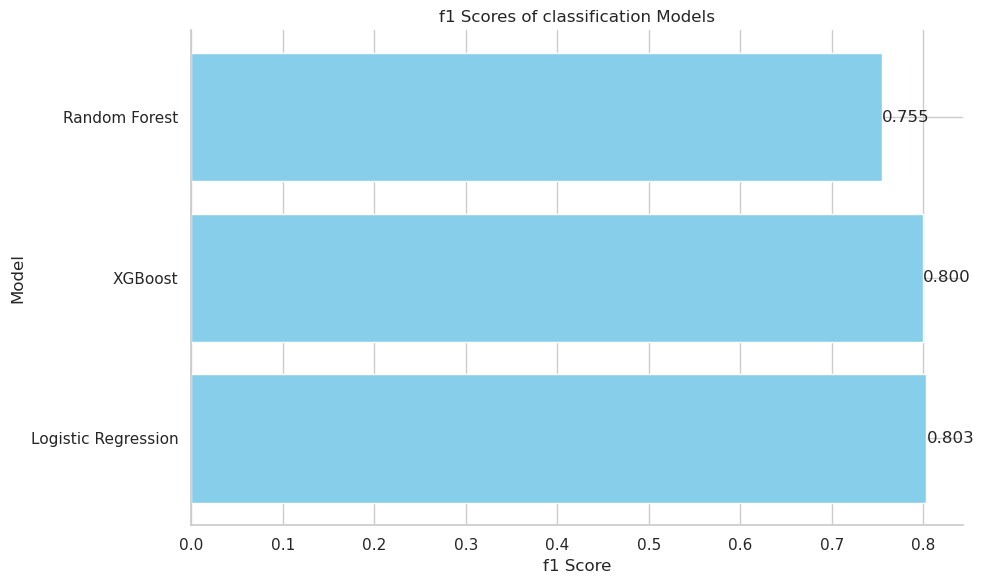

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# f1 scores
f1_scores = [0.80347, 0.8001, 0.7549]

# Model names
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest']

# Set style using Seaborn
sns.set(style='whitegrid')

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, f1_scores, color='skyblue')

# Add data labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', ha='left', va='center')

# Remove spines
sns.despine()

# Add labels and title
plt.xlabel('f1 Score')
plt.ylabel('Model')
plt.title('f1 Scores of classification Models')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Inference

1. Logistic Regression after performing some Hyperparameter tuning gave best results among other models.

2. Overall Model Performance: The logistic regression model with hyperparameter tuning achieved an accuracy of 80% on the test data. This means that 80% of the predictions made by the model were correct.

3. Precision and Recall: The precision for the "POSITIVE" class is 0.75, indicating that when the model predicts a review as "POSITIVE," it is correct 75% of the time. The recall for the "POSITIVE" class is 0.60, suggesting that the model identifies only 60% of the actual "POSITIVE" reviews. Similarly, for the "NEGATIVE" class, the precision is 0.82 (correct 82% of the time) and the recall is 0.90 (identifies 90% of actual "NEGATIVE" reviews).

4. F1-Score: The F1-score is a metric that balances precision and recall. The weighted average F1-score is 0.80, which is a measure of the model's overall performance across both classes.

# Submission

In [ ]:
# Save the predictions to a CSV file
submission = pd.DataFrame({
    'id': range(len(test)),  # Create the 'id' column starting with 0
    'sentiment': y_pred_test  # Add the predicted sentiment values
})
submission['sentiment'] = submission['sentiment'].map({1: 'POSITIVE', 0: 'NEGATIVE'})
submission.to_csv('submission.csv', index=False)